In [82]:
!pip install tensorflow_datasets
!pip install ipywidgets


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


In [2]:
print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.16.1
Num GPUs Available:  0


In [16]:
#data_dir = "G:/Meine Ablage/Colab Notebooks/data/processed/"
data_dir = "../data/raw/"

batch_size = 32
img_height = 64
img_width = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_batches = tf.data.experimental.cardinality(val_ds)

print("Batches:", val_batches.numpy())
test_ds = val_ds.take((2 * val_batches) // 3) # 20% of entire dataset
val_ds = val_ds.skip((2 * val_batches) // 3) # 10% of entire dataset

class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Should be 51 instead of 50 classes. Missing: "Shepherd's Purse" - assumption: This is because of the apostroph --> to be checked


Found 60718 files belonging to 50 classes.
Using 42503 files for training.
Found 60718 files belonging to 50 classes.
Using 18215 files for validation.
Batches: 570
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Black-grass', 'Blueberry___healthy', 'Charlock', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Fat Hen', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Loose Silky-bent', 'Maize', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Scentless Mayweed', 'Small-flowered Cranesbill', 'Soyb

In [17]:
# Building our (LeNet) model
output_shape = len(class_names)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.Conv2D(filters = 30, kernel_size = (5,5), padding="valid", activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = 'valid', activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate = 0.2))
model.add(tf.keras.layers.Dense(units = 128, activation = "relu"))
model.add(tf.keras.layers.Dense(units = output_shape, activation = "softmax"))


In [18]:
#%%time

model.compile(optimizer='adam',
                   loss="SparseCategoricalCrossentropy",
                   metrics=['accuracy'])

epochs = 50

training_history = model.fit(train_ds, validation_data = val_ds, epochs = epochs, batch_size = batch_size)


Epoch 1/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 309s 232ms/step - accuracy: 0.4504 - loss: 2.0584 - val_accuracy: 0.7447 - val_loss: 0.8255
Epoch 2/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.7477 - loss: 0.8079 - val_accuracy: 0.8170 - val_loss: 0.6066
Epoch 3/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.8099 - loss: 0.5921 - val_accuracy: 0.8302 - val_loss: 0.5381
Epoch 4/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8462 - loss: 0.4811 - val_accuracy: 0.8358 - val_loss: 0.5231
Epoch 5/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8664 - loss: 0.3990 - val_accuracy: 0.8497 - val_loss: 0.4946
Epoch 6/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8826 - loss: 0.3537 - val_accuracy: 0.8560 - val_loss: 0.4669
Epoch 7/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.8944 - loss: 0.3139 - val_accuracy: 0.8319 - val_loss: 0.5778
Epoch 8/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.9015

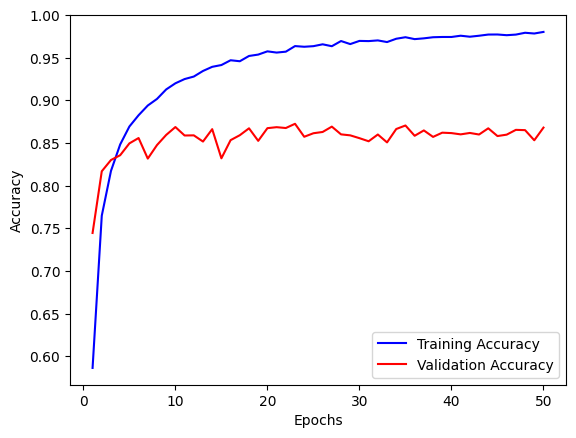

In [20]:
# Assessing the training history
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

# Axis labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Precision curve on the training sample
plt.plot(np.arange(1 , epochs + 1, 1),
         training_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Accuracy curve on the test sample
plt.plot(np.arange(1 , epochs + 1, 1),
         training_history.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

plt.legend()
plt.show()

In [21]:
# Assess results on test_ds
predictions = np.array([])
labels =  np.array([])

for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)]).astype(int)
  labels = np.concatenate([labels, y.numpy()]).astype(int)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [22]:
# Classification report
from sklearn.metrics import classification_report

c_true = np.array(class_names)[labels]
c_predict = np.array(class_names)[predictions]

print("LeNet")
print(classification_report(c_true, c_predict))

LeNet
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.74      0.73      0.74       126
                            Apple___Black_rot       0.91      0.91      0.91       127
                     Apple___Cedar_apple_rust       0.66      0.70      0.68        57
                              Apple___healthy       0.90      0.84      0.87       339
                    Background_without_leaves       0.94      0.84      0.89       235
                                  Black-grass       0.42      0.30      0.35        63
                          Blueberry___healthy       0.93      0.97      0.95       312
                                     Charlock       0.81      0.81      0.81        77
                      Cherry___Powdery_mildew       0.94      0.85      0.89       227
                             Cherry___healthy       0.85      0.99      0.91       168
                                    

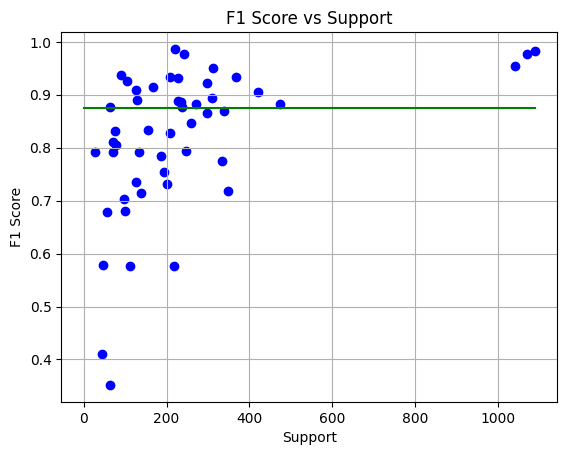

In [23]:
# Scatter plot on F1 score in relation to support
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, support = precision_recall_fscore_support(labels, predictions)

f1score = classification_report(labels, predictions, output_dict=True)["weighted avg"]["f1-score"]

# Create the scatterplot
plt.scatter(support, fscore, marker='o', color='b')

plt.plot((0, support.max()), (f1score, f1score),
         label = 'F1 Score',
         color = 'green')

plt.xlabel("Support")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Support")
plt.grid(True)
plt.show()


In [13]:
# Confusion matrix
print("LeNet")
pd.crosstab(c_true, c_predict, rownames=['Real classification'], colnames=['Predicted classification'])


LeNet


Predicted classification,Apple___Apple_scab,Apple___Black_rot,Apple___Cedar_apple_rust,Apple___healthy,Background_without_leaves,Black-grass,Blueberry___healthy,Charlock,Cherry___Powdery_mildew,Cherry___healthy,...,Tomato___Bacterial_spot,Tomato___Early_blight,Tomato___Late_blight,Tomato___Leaf_Mold,Tomato___Septoria_leaf_spot,Tomato___Spider_mites Two-spotted_spider_mite,Tomato___Target_Spot,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_mosaic_virus,Tomato___healthy
Real classification,,,,,,,,,,,,,,,,,,,,,
Apple___Apple_scab,80,3,0,7,0,0,1,0,0,0,...,1,0,4,4,8,0,0,0,0,1
Apple___Black_rot,0,110,0,3,0,0,0,0,0,1,...,0,0,1,0,8,0,0,1,0,0
Apple___Cedar_apple_rust,1,0,39,0,0,0,0,0,4,0,...,4,0,1,0,1,1,1,2,0,1
Apple___healthy,12,1,0,270,4,0,3,0,2,1,...,1,2,2,8,5,1,8,1,0,2
Background_without_leaves,0,1,0,1,213,4,0,0,1,0,...,0,2,4,0,0,0,0,0,0,0
Black-grass,0,0,0,0,6,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Blueberry___healthy,8,5,0,5,0,0,246,0,0,0,...,0,2,3,3,11,3,0,2,3,0
Charlock,0,0,0,0,0,0,0,60,0,0,...,0,0,1,0,0,0,0,0,0,0
Cherry___Powdery_mildew,0,0,2,1,2,0,0,0,194,0,...,1,0,3,2,0,0,0,1,0,0


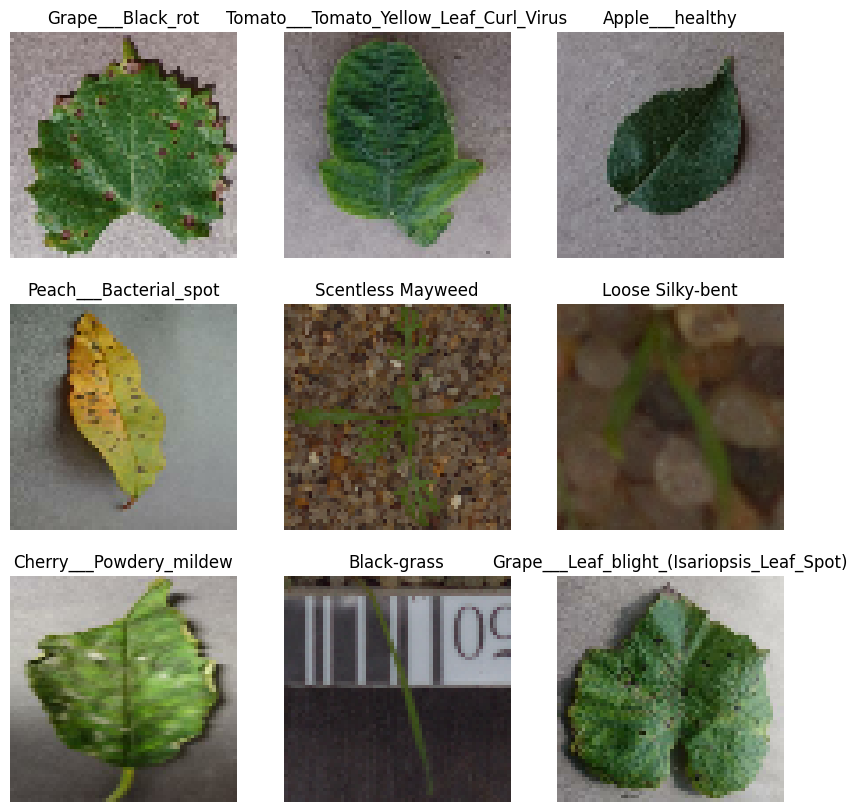

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
